## Comparing Strain Sensor on Index MCP to time

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from config import path_to_repository
from analysis import BallBearingData # class for extracting all data from application and reapplication for ADC, IMU, and Camera Triggers
from analysis import DLC3DBendAngles # class for taking DLC 3d point data and converting to angles 
from analysis import bender_class # class for normalizing adc data, analyzing autobender tests
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:3651: SyntaxWarning: invalid escape sequence '\D'
  ax[0].set_ylabel('$\Delta R/R_o$')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:3658: SyntaxWarning: invalid escape sequence '\D'
  ax[1].set_ylabel('$\Delta R/R_o$')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:3947: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_ylabel('$\Delta R/R_o$', color='b')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:3962: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_xlabel('$\epsilon$ (strain)')


In [4]:
# Upload ball bearing and beaker Trials from particpant 9_9_25

bb = BallBearingData(
    root_dir="CSV Data/9_9_25",
    path_to_repo=path_to_repository,
    n_trials_per_set=30,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=6,
    folder_suffix="R",     # this suffic contains data from ball bearing AND beaker reach to grasp tasks 
)
df_first  = bb.load_first()
df_second = bb.load_second()

adc_trials_first = bb.extract_adc_dfs_by_trial(df_first)  # list of 30 DataFrames
adc_trials_second = bb.extract_adc_dfs_by_trial(df_second)  # list of 30 DataFrames
trial1_adc = adc_trials_first[0]  # trial 1 (index 0)



Found 69 *_R folders total.
First set range: 2025_09_09_13_06_57_R → 2025_09_09_13_26_20_R
Second set range: 2025_09_09_13_55_33_R → 2025_09_09_14_09_51_R
ball_bearing_first: All trials have 6 CSVs ✅
ball_bearing_second: All trials have 6 CSVs ✅


In [5]:
#example of how to extract single adc trial data
trial1_adc = trial1_adc[["timestamp","adc_ch0","adc_ch1","adc_ch2","adc_ch3"]].copy()

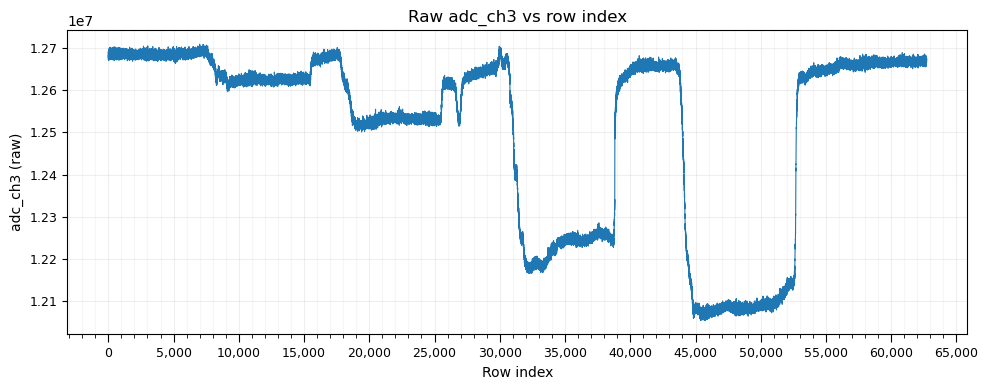

In [6]:
import matplotlib.ticker as mticker

# Analyzing strain sensor block calibration data.  One continuous adc timeseries collected, and mcp is bent sequentualls at the following angles:  
# 0, 22.5, 45, 67.5, 90 deg

# --- first calibration---
h_cal_path = os.path.join(
    path_to_repository,
    "CSV Data/9_9_25/block calibration/2025_09_18_09_56_56_R/data_spacebar_2025_09_18_09_56_56.csv"
)

# Derive matching ADC file
adc_path = h_cal_path.replace("data_spacebar_", "data_adc_")

# Load ADC CSV and pull adc_ch3 as a numeric Series
adc_df = pd.read_csv(adc_path)
y_raw = pd.to_numeric(adc_df["adc_ch3"], errors="coerce")

# Optional: downsample for speed if huge (keep every 'step' point)
step = 1  # set to 2/3/... to thin the plot
y_plot = y_raw.iloc[::step].reset_index(drop=True)
x_plot = np.arange(len(y_plot))

# ---- Plot: raw adc_ch3 vs row index with denser ticks ----
plt.figure(figsize=(10, 4))
plt.plot(x_plot, y_plot.values, linewidth=0.8)

ax = plt.gca()

# 1) More major ticks (aim for ~15 labeled ticks)
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15, prune=None))

# 2) Minor ticks between majors (e.g., 5)
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))

# 3) Make ticks readable
ax.tick_params(axis="x", which="major", length=6)
ax.tick_params(axis="x", which="minor", length=3)
ax.tick_params(axis="both", which="both", labelsize=9)

# 4) Show thousands separators on x
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v):,}"))

plt.xlabel("Row index")
plt.ylabel("adc_ch3 (raw)")
plt.title("Raw adc_ch3 vs row index")
plt.grid(alpha=0.2, which="major")
plt.grid(alpha=0.1, which="minor", axis="x")
plt.tight_layout()
plt.show()


Counts per angle:
angle
0.0     500
22.5    500
45.0    500
67.5    500
90.0    500
Name: adc_ch3, dtype: int64

Quadratic fit: ADC = a + b·θ + c·θ²
  a = 1.26937e+07,  b = -1824.06,  c = -57.8007
  R² = 0.982227


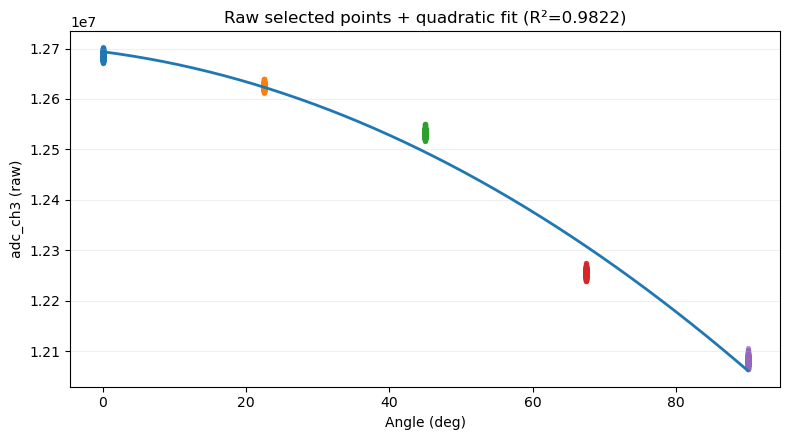

In [7]:
# --- given marker file path  ---
h_cal_path = os.path.join(
    path_to_repository,
    "CSV Data/9_9_25/block calibration/2025_09_18_09_56_56_R/data_spacebar_2025_09_18_09_56_56.csv"
)

# Derive matching ADC file
adc_path = h_cal_path.replace("data_spacebar_", "data_adc_")

# Load ADC CSV and pull adc_ch3 as a numpy array
adc_df = pd.read_csv(adc_path)
y = pd.to_numeric(adc_df["adc_ch3"], errors="coerce").to_numpy()

# === USER INPUT: five (start_row, end_row) ranges, in order of angles ===
# Example (replace with actual row ranges)
ranges = [
    (  500,  1000),    # 0°
    (13000,  13500),   # 22.5°
    (24000,  24500),   # 45°
    (38000,  38500),   # 67.5°
    (48000,  48500),   # 90°
]

angles = [0.0, 22.5, 45.0, 67.5, 90.0]

# Optional: keep at most N consecutive points per range (set to None for all)
max_points_per_range = None   # e.g., 200

# --- Build the angle→adc DataFrame ---
parts = []
for (start, end), ang in zip(ranges, angles):
    # clamp to valid indices
    start = int(max(0, start))
    end   = int(min(len(y), end))
    if end <= start:
        continue

    vals = y[start:end]
    # drop NaNs if any
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        continue

    if max_points_per_range is not None and vals.size > max_points_per_range:
        # choose the flattest consecutive window of length max_points_per_range
        k = max_points_per_range
        c1 = np.concatenate(([0.0], np.cumsum(vals)))
        c2 = np.concatenate(([0.0], np.cumsum(vals*vals)))
        sum_y  = c1[k:] - c1[:-k]
        sum_y2 = c2[k:] - c2[:-k]
        mean_y = sum_y / k
        var_y  = np.maximum(sum_y2 / k - mean_y**2, 0.0)
        i0 = int(np.argmin(var_y))
        vals = vals[i0:i0+k]

    parts.append(pd.DataFrame({"angle": ang, "adc_ch3": vals}))

angle_adc_df = (pd.concat(parts, ignore_index=True)
                if parts else pd.DataFrame(columns=["angle","adc_ch3"]))

# --- Quick summary ---
print("Counts per angle:")
print(angle_adc_df.groupby("angle")["adc_ch3"].size())

# === Quadratic fit on selected points (ADC = a + b*theta + c*theta^2) + R^2 ===
if not angle_adc_df.empty and angle_adc_df["angle"].nunique() >= 3:
    x_fit = angle_adc_df["angle"].to_numpy(float)
    y_fit = angle_adc_df["adc_ch3"].to_numpy(float)

    # Fit returns [c2, c1, c0] for c2*x^2 + c1*x + c0
    c2, c1, c0 = np.polyfit(x_fit, y_fit, deg=2)
    y_hat = c0 + c1*x_fit + c2*(x_fit**2)

    ss_res = np.sum((y_fit - y_hat)**2)
    ss_tot = np.sum((y_fit - y_fit.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    print("\nQuadratic fit: ADC = a + b·θ + c·θ²")
    print(f"  a = {c0:.6g},  b = {c1:.6g},  c = {c2:.6g}")
    print(f"  R² = {r2:.6f}")

    # --- Single plot: raw points (vertical bands) + fitted curve ---
    plt.figure(figsize=(8,4.5))
    for ang in angles:
        yy_band = angle_adc_df.loc[angle_adc_df["angle"] == ang, "adc_ch3"].to_numpy()
        if yy_band.size:
            xx_band = np.full_like(yy_band, ang, dtype=float)
            plt.scatter(xx_band, yy_band, s=8, alpha=0.6)

    xx = np.linspace(min(angles), max(angles), 300)
    yy_curve = c0 + c1*xx + c2*(xx**2)
    plt.plot(xx, yy_curve, linewidth=2)

    plt.xlabel("Angle (deg)")
    plt.ylabel("adc_ch3 (raw)")
    plt.title(f"Raw selected points + quadratic fit (R²={r2:.4f})")
    plt.grid(alpha=0.2, axis="y")
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to fit (need points from ≥3 distinct angles).")





Quadratic fit on selected points: ADC = a + b·θ + c·θ²
  a = 1.26937e+07,  b = -1824.06,  c = -57.8007
  R² = 0.982227
Loaded merged_df with 2500 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
Estimated radius r ≈ 0.6768 in  (95% CI: 0.6645, 0.6890),  R²=0.9761
[find_matching_indices] Dropping 0 camera rows with NaT timestamps.
[find_matching_indices] Dropping 0 encoder rows with NaT timestamps.
[debug] cam range: 0 days 11:48:43.652923 → 0 days 11:48:53.651709
[debug] enc range: 0 days 11:48:43.666324 → 0 days 11:48:53.643426
[debug] probe |delta| (ms) stats: count    21.000000
mean      6.750333
std       3.395231
min       0.376000
25%       4.194000
50%       7.479000
75%       9.427000
max      13.401000
Name: delta_ms, dtype: float64
Loaded merged_df with 6505 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
Estimated radius r ≈ 0.3253 in  (95% CI: 0.3210, 0.3296),  R²=0.9927


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:1003: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:1004: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


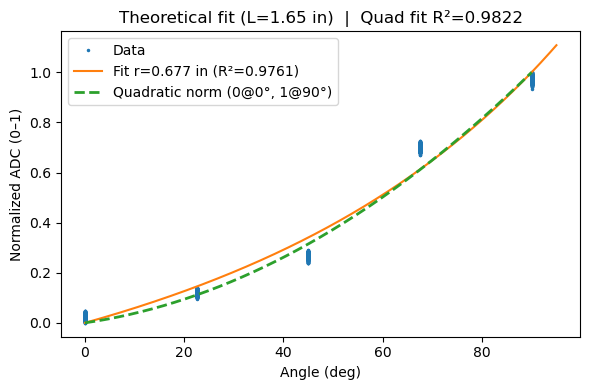

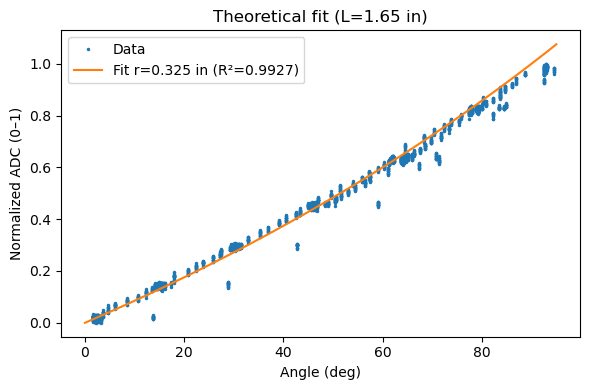

In [8]:


# 1) Quadratic fit on selected raw points: ADC = a + b*theta + c*theta^2
x_fit = angle_adc_df["angle"].to_numpy(float)
y_fit = angle_adc_df["adc_ch3"].to_numpy(float)

c2, c1, c0 = np.polyfit(x_fit, y_fit, deg=2)  # returns [c2, c1, c0]
p = np.poly1d([c2, c1, c0])
y_hat = p(x_fit)

ss_res = np.sum((y_fit - y_hat)**2)
ss_tot = np.sum((y_fit - y_fit.mean())**2)
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

print("\nQuadratic fit on selected points: ADC = a + b·θ + c·θ²")
print(f"  a = {c0:.6g},  b = {c1:.6g},  c = {c2:.6g}")
print(f"  R² = {r2:.6f}")

# 2) Smooth curve over 0..90 deg
theta_line = np.linspace(0.0, 90.0, 400)
yy_raw = p(theta_line)

# 3) Normalize curve to 0–1 with 0 at 0 deg, 1 at 90deg (auto-flip if needed)
y0, y90 = float(p(0.0)), float(p(90.0))
if y90 >= y0:
    yy_norm = (yy_raw - y0) / max(1e-12, (y90 - y0))
else:
    # ADC decreases with angle → flip so it rises from 0 to 1
    yy_norm = (y0 - yy_raw) / max(1e-12, (y0 - y90))

# --- Now run bender class pipeline and overlay on the same axes ---
g = bender_class()
g.load_merged_df(angle_adc_df, enc_col="angle", adc_col="adc_ch3")
g.normalize_adc_bw_01()

# 3) Determine theoretical knuckle radius R from best-theoretical model fit to data.  Curve will depend on knuckle radius R, and sample length L
# This function also plot the best fit to the data
# As a reminder, this data is from sensor on hand on calibration block
res = g.fit_knuckle_radius_from_normalized(L=1.65, r0=0.5, plot=True, flip_data=False)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  "
      f"(95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")

# 4) Overlay the normalized quadratic curve on top of theoretical curve
ax = plt.gca()
ax.plot(theta_line, yy_norm, linestyle="--", linewidth=2,
        label="Quadratic norm (0@0°, 1@90°)")
ax.legend()
ax.set_title(ax.get_title() + f"  |  Quad fit R²={r2:.4f}" if ax.get_title() else f"Quad fit R²={r2:.4f}")
plt.tight_layout()
plt.show

#############################################################################

# 5) Plot on separate plot, norm 0-1 of strain sensor on autobender, just for comparison....Keep this analysis in back pocket in case possible to make a 
# *Master* curve in future, simplify greatly any calibration process

renc = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_rotenc_2025_09_09_11_48_41.csv")
strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_adc_2025_09_09_11_48_41.csv")
strain_df = pd.read_csv(strain)
renc_df   = pd.read_csv(renc)
cam = DLC3DBendAngles(strain_df)

# --- build match map: STRAIN timestamps ↔ ENCODER timestamps ---
# If  time columns have a different name, change both "timestamp" strings below.
cam.find_matching_indices(
    encoder_df=renc_df,
    cam_time_col="timestamp",   # column in strain_df
    enc_time_col="timestamp",   # column in renc_df
    tolerance="10ms",          # e.g., "50ms", "0.1s", "500us"
    direction="nearest",        # "nearest" | "forward" | "backward"
)

# --- attach chosen encoder columns onto the (matched) STRAIN rows ---
# columns=None attaches all encoder columns; or use ["angle_renc"] (etc.) to pick specific ones.
merged_df = cam.attach_encoder_using_match(
    encoder_df=renc_df,
    columns=None,          # or e.g. ["angle_renc", "timestamp"]
    suffix="_renc",        # encoder cols will be suffixed, e.g., "angle_renc_renc"
    keep_time_delta=True,  # adds "time_delta_renc" (ms) to inspect match quality
    drop_unmatched=True,   # keep only strain rows that found a match
)


g = bender_class()


# direct from aligned DataFrame
g.load_merged_df(merged_df, enc_col="angle_renc", adc_col="adc_ch3")
# now reuse existing methods
g.normalize_adc_bw_01()

# Again, from 5) Plot on separate plot, norm 0-1 of strain sensor on autobender, just for comparison....Keep this analysis in back pocket in case possible to make a 
# *Master* curve in future, simplify greatly any calibration process

res = g.fit_knuckle_radius_from_normalized(L=1.65, r0=0.5, plot=True, flip_data=True)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  (95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")
R_fit = res['r_hat']   # e.g. 0.40 in



In [9]:
# 2) Fit the quadratic ONCE from selected calibration data, then register calibration with the class
x_fit = angle_adc_df["angle"].to_numpy(float)
y_fit = angle_adc_df["adc_ch3"].to_numpy(float)
c2, c1, c0 = np.polyfit(x_fit, y_fit, deg=2)

bb.set_calibration(angle_adc_df, coeffs=(c2, c1, c0))  # stores y0_fit/y90_fit and empirical anchors

# 3) Produce tall, plot-ready frames (timestamps preserved)
theta_all_first  = bb.trials_to_tall_df(adc_trials_first,  set_label="first",  trial_len_sec=10.0)
theta_all_second = bb.trials_to_tall_df(adc_trials_second, set_label="second", trial_len_sec=10.0)
theta_all = pd.concat([theta_all_first, theta_all_second], ignore_index=True)


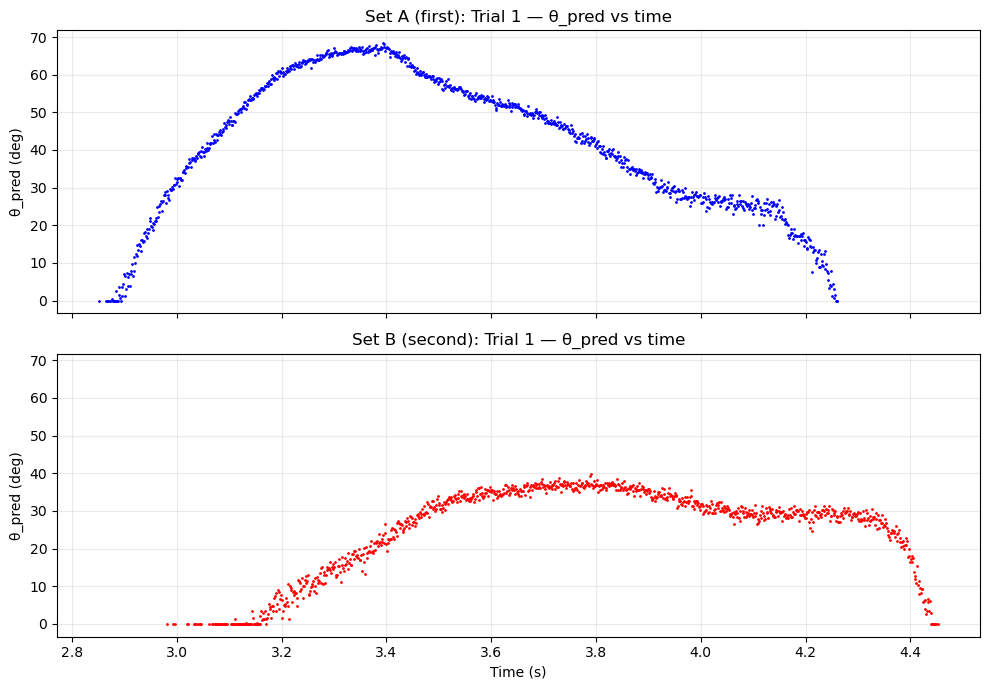

In [10]:
# Plot first trial for both 1st application (blue) and reapplication (red)
# Need to double check with Phil, but first 15 of each should be ball bearing, 16-30 beaker

# Filter trial 1 from each set
A1 = theta_all[(theta_all["set_label"] == "first")  & (theta_all["trial"] == 2)]
B1 = theta_all[(theta_all["set_label"] == "second") & (theta_all["trial"] == 2)]

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# Top: FIRST set (blue) – trial 1
if not A1.empty:
    axes[0].plot(A1["time_s"], A1["theta_pred_deg"], ".", markersize=2, color="blue")
axes[0].set_title("Set A (first): Trial 1 — θ_pred vs time")
axes[0].set_ylabel("θ_pred (deg)")
axes[0].grid(alpha=0.25)

# Bottom: SECOND set (red) – trial 1
if not B1.empty:
    axes[1].plot(B1["time_s"], B1["theta_pred_deg"], ".", markersize=2, color="red")
axes[1].set_title("Set B (second): Trial 1 — θ_pred vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_pred (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()


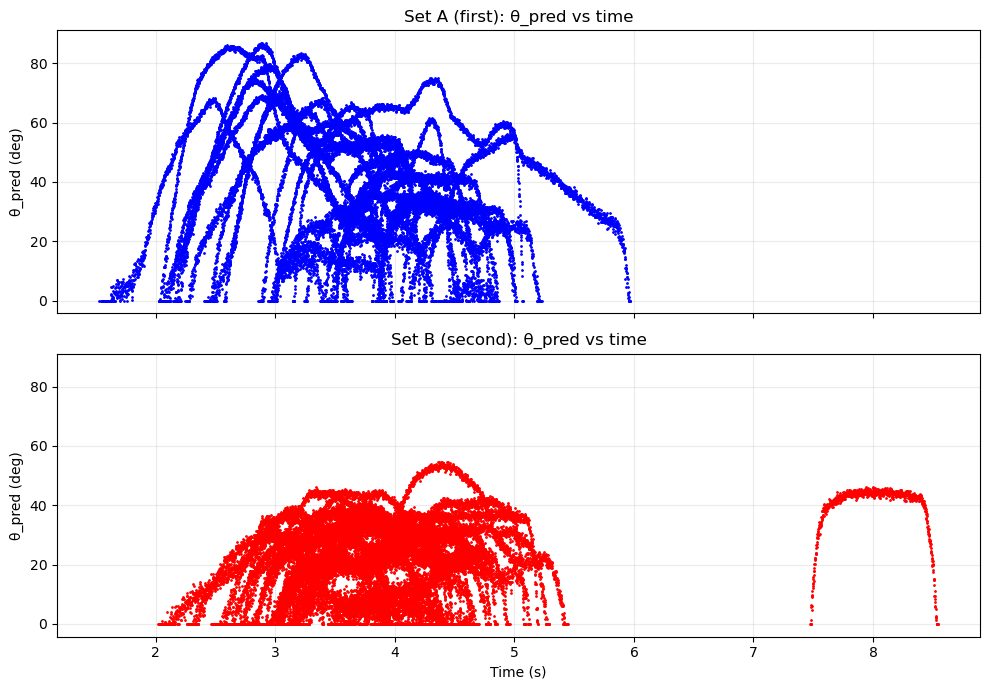

In [11]:
# Plotting all 30 trials 1st application and 1st reapplication data here for strain sensor

# Split by set
A = theta_all[theta_all["set_label"] == "first"]
B = theta_all[theta_all["set_label"] == "second"]

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# Top: FIRST set (blue)
for trial_i in sorted(A["trial"].unique()):
    df = A[A["trial"] == trial_i]
    if not df.empty:
        axes[0].plot(df["time_s"], df["theta_pred_deg"], ".", markersize=2, color="blue")
axes[0].set_title("Set A (first): θ_pred vs time")
axes[0].set_ylabel("θ_pred (deg)")
axes[0].grid(alpha=0.25)

# Bottom: SECOND set (red)
for trial_i in sorted(B["trial"].unique()):
    df = B[B["trial"] == trial_i]
    if not df.empty:
        axes[1].plot(df["time_s"], df["theta_pred_deg"], ".", markersize=2, color="red")
axes[1].set_title("Set B (second): θ_pred vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_pred (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()


In [12]:
# Match trial ADC timestamps to camera trigger timestamps -> need for error analysis
# See jupyter notebook camera_encoder_cal.ipnyb.  This file compares the camera 3d data with timestamps to encoder data from autobender with timestamps

# Waiting for Phil to give me 3d DLC position data

## IMU Analysis of Wrist Bend Angles Here

In [14]:

# 2) Extract IMU trials (same calls as before)
imu_trials_first  = bb.extract_imu_dfs_by_trial(df_first)      # list length = bb.n_trials_per_set
imu_trials_second = bb.extract_imu_dfs_by_trial(df_second)

print(f"First set:  {len(imu_trials_first)} IMU trials")
print(f"Second set: {len(imu_trials_second)} IMU trials")

# 3) Access a single trial (unchanged)
trial1_imu = imu_trials_first[0]   # 0-based index -> trial 1
print("Trial 1 IMU columns:", list(trial1_imu.columns))


First set:  30 IMU trials
Second set: 30 IMU trials
Trial 1 IMU columns: ['timestamp', 'adc_ch0', 'adc_ch1', 'adc_ch2', 'adc_ch3', 'application_set', 'trial_index', 'file_index', 'folder_name', 'source_folder', 'source_file', 'source_path', 'timestamp_folder', 'quat1', 'quat2', 'raw', 'volts', 'angle', 'marker', 'trigger_count']


In [15]:

# Extract trigger-time trials (same calls)
trigger_trials_first  = bb.extract_trigger_dfs_by_trial(df_first)
trigger_trials_second = bb.extract_trigger_dfs_by_trial(df_second)

print(f"First set:  {len(trigger_trials_first)} trigger-time trials")
print(f"Second set: {len(trigger_trials_second)} trigger-time trials")

# Access a single trial
trial1_trigger = trigger_trials_first[0]   # 0-based index -> trial 1
print("Trial 1 trigger-time columns:", list(trial1_trigger.columns))


First set:  30 trigger-time trials
Second set: 30 trigger-time trials
Trial 1 trigger-time columns: ['timestamp', 'adc_ch0', 'adc_ch1', 'adc_ch2', 'adc_ch3', 'application_set', 'trial_index', 'file_index', 'folder_name', 'source_folder', 'source_file', 'source_path', 'timestamp_folder', 'quat1', 'quat2', 'raw', 'volts', 'angle', 'marker', 'trigger_count']


In [ ]:


# 3) Augment IMU trials in place (adds time_s + imu_joint_deg_rx_py, preserves original 'timestamp')
bb.imu_augment_trials_inplace(trigger_trials_first,  imu_trials_first,  trial_len_sec=10.0)
bb.imu_augment_trials_inplace(trigger_trials_second, imu_trials_second, trial_len_sec=10.0)

# 4) Build tall frames for plotting
A_all = bb.imu_collect_tall(imu_trials_first,  "first")
B_all = bb.imu_collect_tall(imu_trials_second, "second")

print(f"[A] non-empty trials: {A_all['trial'].nunique() if not A_all.empty else 0}, rows: {len(A_all)}")
print(f"[B] non-empty trials: {B_all['trial'].nunique() if not B_all.empty else 0}, rows: {len(B_all)}")

# 5) Quick plot (same style you’ve been using)
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

for tr in sorted(A_all["trial"].unique()) if not A_all.empty else []:
    d = A_all[A_all["trial"] == tr]
    axes[0].plot(d["time_s"], d["imu_joint_deg_rx_py"], ".", markersize=2, color="blue")
axes[0].set_title("Set A: θ_IMU(t)")
axes[0].set_ylabel("θ_IMU (deg)")
axes[0].grid(alpha=0.25)

for tr in sorted(B_all["trial"].unique()) if not B_all.empty else []:
    d = B_all[B_all["trial"] == tr]
    axes[1].plot(d["time_s"], d["imu_joint_deg_rx_py"], ".", markersize=2, color="red")
axes[1].set_title("Set B: θ_IMU(t)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_IMU (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()


In [ ]:
# ---------- plot ----------
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

for tr in sorted(A_all["trial"].unique()) if not A_all.empty else []:
    dfp = A_all[A_all["trial"] == tr]
    axes[0].plot(dfp["time_s"], dfp["imu_joint_deg_rx_py"], ".", markersize=2, color="blue")
axes[0].set_title("Set A: θ_IMU(t) appended to original IMU trials")
axes[0].set_ylabel("θ_IMU (deg)")
axes[0].grid(alpha=0.25)

for tr in sorted(B_all["trial"].unique()) if not B_all.empty else []:
    dfp = B_all[B_all["trial"] == tr]
    axes[1].plot(dfp["time_s"], dfp["imu_joint_deg_rx_py"], ".", markersize=2, color="red")
axes[1].set_title("Set B: θ_IMU(t) appended to original IMU trials")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_IMU (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()